In [1]:
import numpy as np

def pca_transform(data, n_components):
    # Reshape the data if necessary
    data = data.reshape(data.shape[0], -1)
    
    # Calculate mean
    mean = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mean
    
    # Calculate covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # Compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    
    # Select top n_components eigenvectors
    pca_matrix = eigenvectors_sorted[:, :n_components]
    
    # Project data onto the principal components
    data_reduced = np.dot(data_centered, pca_matrix )
    
    return data_reduced, pca_matrix

# Load data
mnist_data = np.load('mnist.npz')
X_train = mnist_data['x_train']
y_train = mnist_data['y_train']
x_test = mnist_data['x_test']
y_test = mnist_data['y_test']

# Filter out samples from classes 0 and 1
mask_train = (y_train < 2)
X_train_filtered = X_train[mask_train].reshape(-1, 28*28)
y_train_filtered = y_train[mask_train]

mask_test = (y_test < 2)
x_test_filtered = x_test[mask_test]
y_test_filtered = y_test[mask_test]

# Divide the train set into train and val set
X_val = X_train_filtered[:2000]
y_val = y_train_filtered[:2000]
X_train_filtered = X_train_filtered[2000:]
y_train_filtered = y_train_filtered[2000:]

# Apply PCA and reduce the dimensionality to p = 5
X_reduced_train, pca_matrix  = pca_transform(X_train_filtered, n_components=5)
X_reduced_val = np.dot(X_val.reshape(X_val.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)
x_reduced_test = np.dot(x_test_filtered.reshape(x_test_filtered.shape[0], -1) - np.mean(X_train_filtered, axis=0), pca_matrix)

# Label the classes as -1 and 1
y_train_filtered[y_train_filtered == 0] = -1
y_val[y_val == 0] = -1
y_test_filtered[y_test_filtered == 0] = -1
y_train_filtered[y_train_filtered == 1] = 1
y_val[y_val == 1] = 1
y_test_filtered[y_test_filtered == 1] = 1
print(y_train_filtered.shape)
print(y_val.shape)
print(y_test_filtered.shape)
print("Train set shapes after PCA:", X_reduced_train.shape)
print("Validation set shapes after PCA:", X_reduced_val.shape)
print("Test set shapes after PCA:", x_reduced_test.shape)


(10665,)
(2000,)
(2115,)
Train set shapes after PCA: (10665, 5)
Validation set shapes after PCA: (2000, 5)
Test set shapes after PCA: (2115, 5)


C:\Users\dell\AppData\Local\Temp\ipykernel_21868\3996753751.py:59: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_train_filtered[y_train_filtered == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_21868\3996753751.py:60: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  y_val[y_val == 0] = -1
C:\Users\dell\AppData\Local\Temp\ipykernel_21868\3996753751.py:61: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For th

In [9]:
class DecisionStump():
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_value = None
        self.right_value = None
    
    def fit(self, X, y, sample_weight=None):
        num_samples, num_features = X.shape
        best_missclassification = float('inf')
        
        if sample_weight is None:
            sample_weight = np.ones(num_samples) / num_samples  # Initialize with uniform weights
        
        for feature_index in range(num_features):
            # Sort unique values of the feature
            unique_values = np.unique(X[:, feature_index])
            potential_splits = (unique_values[1:] + unique_values[:-1]) / 2
            
            for threshold in potential_splits:
                predictions = np.ones(num_samples)
                predictions[X[:, feature_index] <= threshold] = -1
                
                missclassification = np.sum(sample_weight[y != predictions])
                
                if missclassification < best_missclassification:
                    best_missclassification = missclassification
                    self.feature_index = feature_index
                    self.threshold = threshold
                    self.left_value = -1
                    self.right_value = 1
    
    def predict(self, X):
        num_samples = X.shape[0]
        predictions = np.ones(num_samples)
        if self.threshold is not None:  # Check if threshold is not None
            predictions[X[:, self.feature_index] <= self.threshold] = -1
        return predictions


# Learn a decision stump using the train set
decision_stump = DecisionStump()
decision_stump.fit(X_reduced_train, y_train_filtered)

# Print the learned decision stump
print("Feature index:", decision_stump.feature_index)
print("Threshold:", decision_stump.threshold)


Feature index: 0
Threshold: (-2318.414134878886+0j)


In [29]:
import matplotlib.pyplot as plt

# Initialize arrays to store alphas and predictions
alphas = []
accuracies = []  # To store accuracies on the validation set

# Initialize weights
weights = np.ones(len(y_train_filtered)) / len(y_train_filtered)  # Initialize weights uniformly

# Epsilon value to avoid division by zero
epsilon = 1e-10

# Iterate to grow decision stumps
for i in range(5):  # Let's grow 5 decision stumps for demonstration
    # Learn a decision stump using the train set
    decision_stump = DecisionStump()
    decision_stump.fit(X_reduced_train, y_train_filtered, sample_weight=weights)
    
    # Compute predictions
    predictions = decision_stump.predict(X_reduced_train)
    
    # Calculate error rate
    error_rate = np.sum(weights * (predictions != y_train_filtered))
    
    # Calculate alpha with epsilon
    alpha = 0.5 * np.log((1 - error_rate + epsilon) / (error_rate +epsilon))
    alphas.append(alpha)
    
    # Update weights based on the classification error
    weights *= np.exp(-alpha * y_train_filtered * predictions)
    weights /= np.sum(weights)
    
    # Compute h1(x) as the prediction of the best stump
    h1_x = np.sign(predictions)
    
    # Compute accuracy on the validation set
    val_predictions = decision_stump.predict(X_reduced_val)
    val_accuracy = np.mean(val_predictions == y_val)
    accuracies.append(val_accuracy)
    
    # Print alpha, h1(x), and validation accuracy for each iteration
    print(f"Iteration {i+1}: Alpha = {alpha}, h1(x) = {h1_x}, Validation Accuracy = {val_accuracy}")




Iteration 1: Alpha = 0.06394072341218682, h1(x) = [1. 1. 1. ... 1. 1. 1.], Validation Accuracy = 0.5345


C:\Users\dell\AppData\Local\Temp\ipykernel_21868\1303750488.py:30: RuntimeWarning: overflow encountered in exp
  weights *= np.exp(-alpha * y_train_filtered * predictions)
C:\Users\dell\AppData\Local\Temp\ipykernel_21868\1303750488.py:31: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)


Iteration 2: Alpha = -3.862675804962227, h1(x) = [1. 1. 1. ... 1. 1. 1.], Validation Accuracy = 0.5345
Iteration 3: Alpha = nan, h1(x) = [1. 1. 1. ... 1. 1. 1.], Validation Accuracy = 0.5345
Iteration 4: Alpha = nan, h1(x) = [1. 1. 1. ... 1. 1. 1.], Validation Accuracy = 0.5345
Iteration 5: Alpha = nan, h1(x) = [1. 1. 1. ... 1. 1. 1.], Validation Accuracy = 0.5345


In [4]:
from q.ipynb import accuraciesr
plt.plot(range(1, 6), accuracies)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy on Validation Set')
plt.title('Accuracy vs. Number of Trees on Validation Set')
plt.show()

# Find the decision stump with the highest accuracy on the validation set
best_iteration = np.argmax(accuracies)
best_decision_stump = DecisionStump()
best_decision_stump.fit(X_reduced_train, y_train_filtered, sample_weight=weights)
best_predictions_test = best_decision_stump.predict(x_reduced_test)
test_accuracy = np.mean(best_predictions_test == y_test_filtered)
print(f"Best Decision Stump Test Accuracy: {test_accuracy}")

ModuleNotFoundError: No module named 'q'

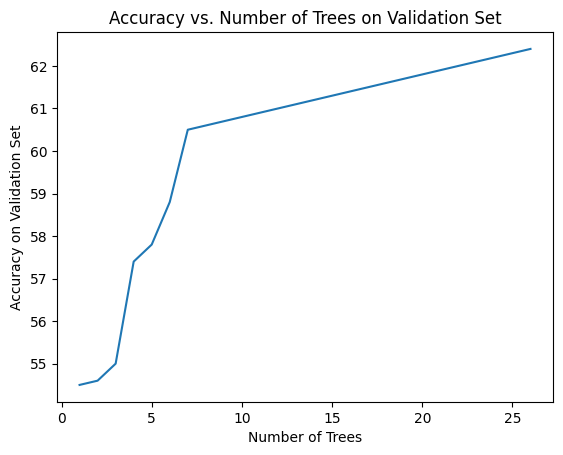

NameError: name 'DecisionStump' is not defined

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1, len(accuraciesr) + 1), accuraciesr)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy on Validation Set')
plt.title('Accuracy vs. Number of Trees on Validation Set')
plt.show()

# Find the decision stump with the highest accuracy on the validation set
best_iteration = np.argmax(accuraciesr)
best_decision_stump = DecisionStump()
best_decision_stump.fit(X_reduced_train, y_train_filtered, sample_weight=weights)
best_predictions_test = best_decision_stump.predict(x_reduced_test)
test_accuracy = np.mean(best_predictions_test == y_test_filtered)
print(f"Best Decision Stump Test Accuracy: {test_accuracy}")
